# Planet : Amazon space

In [1]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.transforms.functional as F

from torchinfo import summary

from tqdm import tqdm

In [2]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

# Loading the dataset
### Understanding the labels

In [3]:
labels_dt = pd.read_csv(f'{data_folder}/train_labels.csv',dtype=str)
tags = pd.Series(labels_dt['tags'].str.split(expand=True).stack().unique())
#print(F"{len(tags)} unique tags are: \n{tags.tolist()} ")
shape1 = labels_dt.shape
for tag in tags:
     a = [(tag in i.split()) for i in labels_dt['tags']]
     new_col = np.zeros(len(a),dtype=int)+a
     #print(new_col.shape)
     labels_dt[tag]=new_col
print(f" \n Shape of the initial dataset {shape1} and final {labels_dt.shape}")
labels_dt.head()

 
 Shape of the initial dataset (40479, 2) and final (40479, 19)


,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


## Making sure the dataset is clean:

In [4]:
def checking_folder(data_folder = data_folder):
    corrupted_files = []
    i = 0
    for img_id in tqdm(labels_dt['image_name']):
        #if i % 1000 == 0:
        #    print(f"image {i}")
        img_name = os.path.join(f'{data_folder}/train-jpg', f'{img_id}.jpg')
        img = imread(img_name)
        if img is None:
            print(f'{img_id} is corrupt...')
            corrupted_files.append(img_id)
        img = None
        i = i + 1
    return corrupted_files

#checking_folder()

## Custom made Class for multilabel classification dataset

See this tutorial for help:
<https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>

In [5]:
class AmazonSpaces(Dataset):
    """Amazon aerial image dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)

        self.tags = self.labels['tags'].str.split(expand=True).stack().unique()
        for tag in self.tags:
            a = [(tag in i.split()) for i in self.labels['tags']]
            self.labels[tag]=np.zeros(len(a),dtype=int)+a

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0])
        img_name = f'{img_name}.jpg'
        image = imread(img_name)
        #image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        labels = self.labels.loc[idx, self.tags].to_numpy(dtype=np.float64)
        #labels = torch.from_numpy(labels)
        #other output
        sample = {'image': image, 'labels': labels}

        #print(type(image), type(labels))
        return sample

In [6]:
Amazon_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg')

## Having some fun with transforms
Just testing some transforms and how to implement into dataset
First creating and Adjust_Saturation class to be able to apply adjust_saturation the same way as the other transforms class

In [7]:
class AdjustSaturation(object):
    """Adjust the saturation of a tensor image.
    Args:
        saturation factor (float): if 0 -> black and white, if 1 -> same as the input
    """

    def __init__(self, saturation_factor):
        assert isinstance(saturation_factor, (int,float))
        self.saturation_factor = saturation_factor

    def __call__(self, img):
        new_tensor = transforms.functional.adjust_saturation(img, self.saturation_factor)

        return new_tensor

Test_transforms = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])

transformed_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg', transform=Test_transforms)

## Visualizing the two datasets:

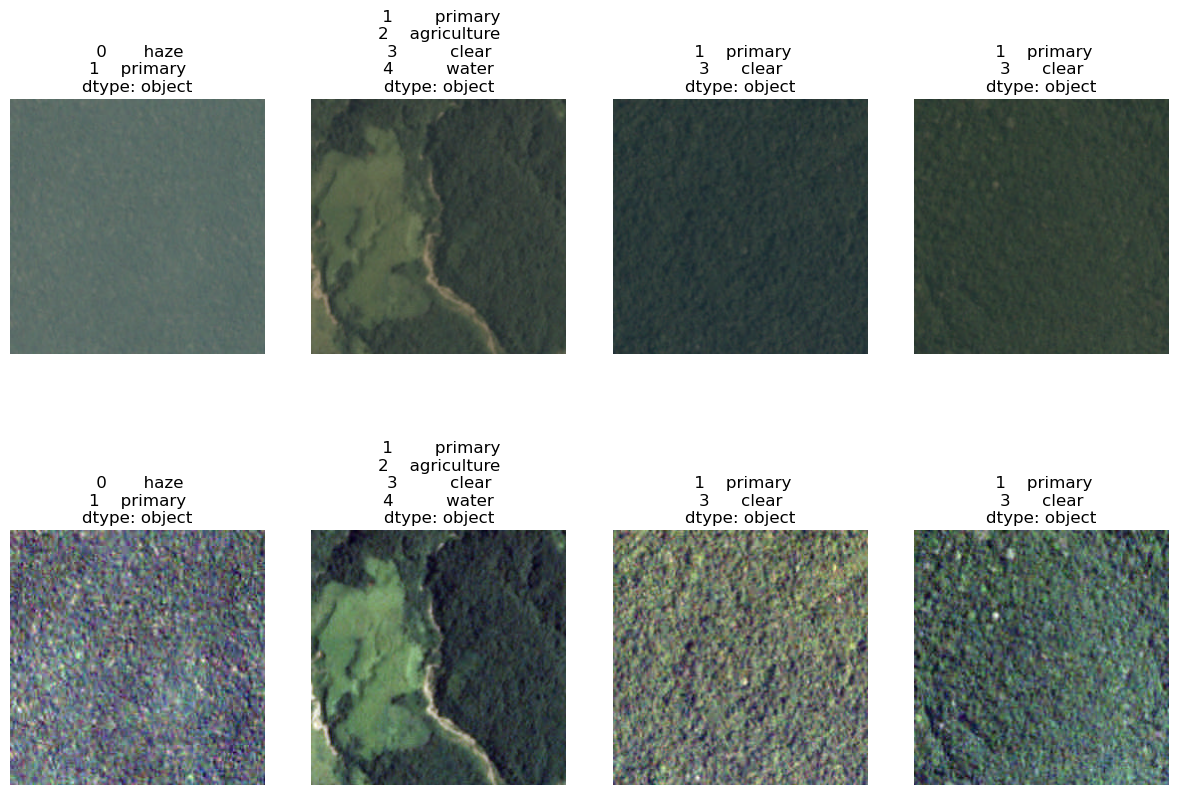

In [8]:
plt.figure(figsize=(12,10))
N=3
for i in range(N+1):
    #Image from original direct dataset
    #image, labels = Amazon_dataset[i]
    sample = Amazon_dataset[i]
    labels = sample['labels']
    image = sample['image']


    ax = plt.subplot(2, N+1, i + 1)
    plt.tight_layout()
    ax.set_title(f' {tags[labels==1]}')
    ax.axis('off')
    img = F.to_pil_image(image)
    ax.imshow(img)

    #Images from transformed_dataset

    sample_tf = transformed_dataset[i]
    labels_tf = sample_tf['labels']
    image_tf = sample_tf['image']

    ax = plt.subplot(2, N+1, i + 5)
    plt.tight_layout()
    ax.set_title(f' {tags[labels_tf==1]}')
    ax.axis('off')
    img = F.to_pil_image(image_tf)
    ax.imshow(img)

plt.show()

# Into Dataloader

In [9]:
train_loader = DataLoader(transformed_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

## Testing with plotting

In [10]:
# Helper function to show a batch
def show_4_image_in_batch(sample_batched, tags = tags):
    images_batch, labels = sample_batched['image'], sample_batched['labels'] #old class output
    #images_batch, labels = sample_batched

    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        img = F.to_pil_image(images_batch[i])
        axs[i].imshow(img)
        ids = labels[i,:].numpy()
        axs[i].set_title(f'#{i}:\n {tags[ids == 1]}')
    fig.set_figheight(10)
    fig.set_figwidth(12)
    plt.tight_layout()
    plt.show()

Batch # 0 with sizes: (torch.Size([64, 3, 256, 256]), torch.Size([64, 17]))
Batch # 1 with sizes: (torch.Size([64, 3, 256, 256]), torch.Size([64, 17]))
Batch # 2 with sizes: (torch.Size([64, 3, 256, 256]), torch.Size([64, 17]))
Batch # 3 with sizes: (torch.Size([64, 3, 256, 256]), torch.Size([64, 17]))


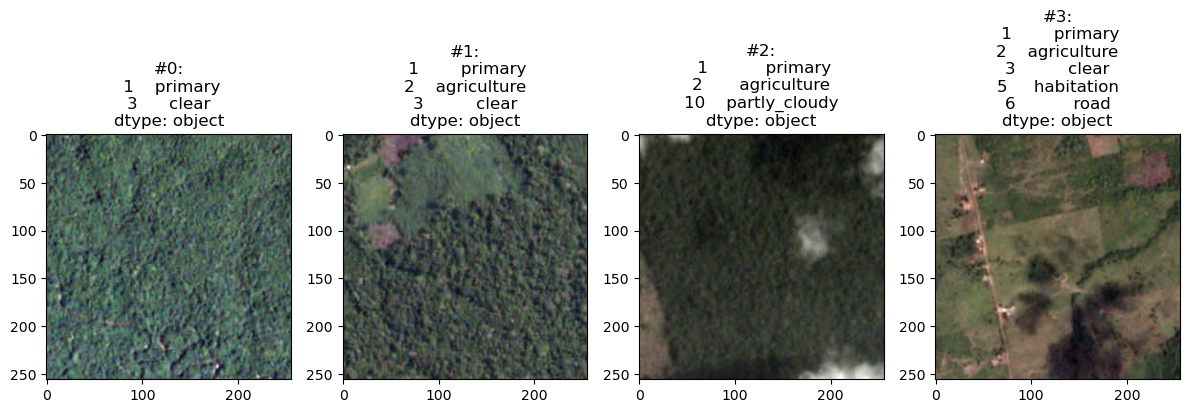

In [11]:
for i_batch, sample_batched in enumerate(train_loader):
    print(f"Batch # {i_batch} with sizes: {sample_batched['image'].size(), sample_batched['labels'].size()}")
    # observe 4th batch and stop.
    if i_batch == 3:
        show_4_image_in_batch(sample_batched)
        break

# Multi-Layer convulotional network
## Model
Function of interest:
* torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
* torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
* torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

In [37]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5) #Input is a 3 plane 256x256 tensor (RBB) -> output 10 planes of 254x254
        self.pool_max = nn.MaxPool2d(2, 2) #output of dim-2 x dim-2
        self.conv2 = nn.Conv2d(10, 20, 5) #input 10 planes 127x127, output 20 planes of 125x125
        self.pool_avg = nn.AvgPool2d(4,4)
        self.fc = nn.Linear(20*27*27,17) #single dense layer for the network
        self.batchNorm = nn.BatchNorm2d(3)
        self.loss = nn.BCELoss()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.batchNorm(x)
        #print(f"step 1 : {x.shape}")
        x = self.pool_max(nn.functional.relu(self.conv1(x)))
        #print(f"step 2 : {x.shape}")
        x = self.pool_avg(x)
        #print(f"step 3 : {x.shape}")
        x = nn.functional.relu(self.conv2(x))
        #print(f"step 4 : {x.shape}")
        x = x.view(-1, 20*27*27)
        #print(f"step 5 : {x.shape}")
        x = self.fc(x)
        return x

In [38]:
net = MultiLayerCNN()
summary(net,input_size=(3,256,256))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

## Training, Validation and accuracy functions

In [149]:
def validate(model, dataloader,device, loss_fn=nn.BCEWithLogitsLoss()):
    mS = nn.Sigmoid()
    net.eval()
    count,acc,loss = 0,0,0
    print('Validating')
    with torch.no_grad():
        for i_batch, sample_batch in tqdm(enumerate(dataloader)):
            image_batch = sample_batch['image'].to(device)
            targets = sample_batched['labels'].to(device)
            # Model Predictions
            out = model(image_batch)
            # Get loss (Sigmoid + Cross Entropy function)
            loss += loss_fn(out,targets)
            # apply sigmoid activation to get all the outputs between 0 and 1
            pred = (mS(out) > 0.6).float()
            acc += (pred==targets).float().mean()
            count += len(targets)
    return loss.item()/count, acc.item()/count

In [170]:
def train_epoch(model,dataloader,device, lr=0.01, optimizer=None,loss_fn = nn.BCEWithLogitsLoss()):
    '''

    :param model: model used for prediction
    :param dataloader: dataloader over the amazon space dataset
    :param lr: learning rate, here default = 0.01
    :param optimizer: Here if None given then using Adam
    :param loss_fn: Loss function default is BCEWithLogitsLoss (sigmoid + cross-entropy)
    :return:
    '''
    mS = nn.Sigmoid()
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    print('Training')
    for i_batch, sample_batch in tqdm(enumerate(dataloader)):
        image_batch = sample_batch['image'].to(device)
        targets = sample_batched['labels'].to(device)
        optimizer.zero_grad()
        #Prediction from model
        out = model(image_batch)
        #Loss function -> sigmoid included in BCEWithLogistLoss
        loss = loss_fn(out,targets)
        total_loss+=loss
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        predicted = (mS(out) > 0.6).float()
        if i_batch == 0:
            print(predicted)
        acc+=(predicted==targets).float().mean()
        count+=len(targets)

        if i_batch % 100 == 0:
            print(f"loss: {total_loss} and acc: {acc.item}")

    return total_loss.item()/count, acc.item()/count

In [171]:
def train(model,train_loader,test_loader,device, optimizer=None,lr=0.01,epochs=2,loss_fn=nn.BCEWithLogitsLoss()):
    '''

    :param model: model to train
    :param train_loader: train dataloader
    :param test_loader: testing dataloader
    :param optimizer: optimizer per default is Adam
    :param lr: default 0.01
    :param epochs: default 2
    :param loss_fn: default BCEWithLogitsLoss (sigmoid + Cross Entropy)
    :return: results as a dictionary with 'train_loss', 'train_acc', 'val_loss', 'val_acc'
    '''
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn,device=device)
        vl,va = validate(net,test_loader,loss_fn=loss_fn, device=device)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Full model running
Ideas from :
<https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/>
## 1) Putting the model on the gpu

In [172]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [173]:
model = MultiLayerCNN().to(device)

## 2) Getting the different datasets

In [174]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [175]:
Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])

In [176]:
train_dataset = AmazonSpaces(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaces(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaces(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

## 3) Wrapping into the different dataloaders

In [177]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## 4) Choice of Criterion and Opitimizer

In [178]:
criterion = nn.BCEWithLogitsLoss()

## 5) TRAINING

In [179]:
The_results = train(model, train_loader, validation_dataset, device=device, loss_fn=criterion)

Training


1it [00:02,  2.38s/it]

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
loss: 0.43533345883754887 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


101it [02:23,  1.35s/it]

loss: 34.298308443057905 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


201it [04:28,  1.16s/it]

loss: 57.928852328562186 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


301it [06:18,  1.16s/it]

loss: 81.42295825220539 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


401it [08:00,  1.01it/s]

loss: 104.9090349354065 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


501it [09:40,  1.27s/it]

loss: 128.36728452640594 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


601it [11:21,  1.01s/it]

loss: 151.82213480636872 and acc: <built-in method item of Tensor object at 0x000002C330AD5030>


632it [11:52,  1.13s/it]


ValueError: Target size (torch.Size([64, 17])) must be the same as input size (torch.Size([31, 17]))

## 6) TESTING

# Saving Models

In [181]:
torch.save(model.state_dict(), "model_simple_classification.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
